<a href="https://colab.research.google.com/github/fausto1364/age-estimation/blob/main/age_estimation_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Age estimation including simplified inception blocks

In [ ]:
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import uuid

# image manipulation
from PIL import Image

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

In [ ]:
# mount drive to access APPA-REAL
from google.colab import drive
drive.mount('/content/drive')

path='/content/drive/MyDrive/appa-real-release/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# just to store comands for Image...
'''image = Image.open(os.path.join(path,'005612.jpg_face.jpg'))
image.show()
print(image.format)
print(image.mode)
print(image.size)
test = image.resize((64,64))
test.show()'''

"image = Image.open(os.path.join(path,'005612.jpg_face.jpg'))\nimage.show()\nprint(image.format)\nprint(image.mode)\nprint(image.size)\ntest = image.resize((64,64))\ntest.show()"

In [ ]:
# extracts only face detected jpegs. Then rescales size of image and converts to numpy matrix
def preprocess(folder_path,size):
  X=[] # contains processed images
  y=[] # contains ids of images
  # regular expression pattern to only extract files with face detection
  pattern = r"\d+\.jpg_face\.jpg"

  # Loop over all files in the folder
  for imagename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, imagename)

    if re.match(pattern, imagename):
      image = Image.open(image_path)
      image = image.resize(size)
      array = [[np.float32(value) for value in row] for row in image.getdata()]
      X.append(np.array(array).reshape(image.size[1], image.size[0], 3))
      y.append(imagename.split(".")[0])
  return X,y

In [ ]:
# read the csv files with the apparent ages
def get_appaages(path):
  id = []
  appa_age = []

  # Read the CSV file
  with open(path, "r") as csv_file:
    csv_reader = csv.reader(csv_file)

    # Skip header
    next(csv_reader)

    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Append the values of the first and third columns to their respective lists
        id.append(row[0].split(".")[0])
        appa_age.append(row[2])

  return appa_age, id

In [ ]:
# allign two lists according to lists with ids
def allign_lists(A,a,B,b):
  X=[]
  Y=[]
  for i in range(len(A)):
    X.append(A[i])
    Y.append(np.float32(B[b.index(a[i])]))

  return np.array(X),np.array(Y)

In [ ]:
# extract and preprocess images
train_path = os.path.join(path, 'train/')
valid_path = os.path.join(path, 'valid/')
test_path = os.path.join(path, 'test/')

images_train,ids_train_im = preprocess(train_path,(64,64))
images_valid,ids_valid_im = preprocess(valid_path,(64,64))
images_test,ids_test_im = preprocess(test_path,(64,64))

# extract apparent ages
gt_train = os.path.join(path, 'gt_avg_train.csv')
gt_valid = os.path.join(path, 'gt_avg_valid.csv')
gt_test = os.path.join(path, 'gt_avg_test.csv')

appaages_train, ids_train_gt = get_appaages(gt_train)
appaages_valid, ids_valid_gt = get_appaages(gt_valid)
appaages_test, ids_test_gt = get_appaages(gt_test)

# sort apparent ages by images through the ids
images_train, appaages_train = allign_lists(images_train, ids_train_im, appaages_train, ids_train_gt)
images_valid, appaages_valid = allign_lists(images_valid, ids_valid_im, appaages_valid, ids_valid_gt)
images_test, appaages_test = allign_lists(images_test, ids_test_im, appaages_test, ids_test_gt)

In [ ]:
# Convert data to PyTorch tensors
train_data = data.TensorDataset(torch.tensor(images_train), torch.tensor(appaages_train))
test_data = data.TensorDataset(torch.tensor(images_test), torch.tensor(appaages_test))
valid_data = data.TensorDataset(torch.tensor(images_valid), torch.tensor(appaages_valid))

# Create dataloaders
batch_size = 32
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_data, batch_size=batch_size)
valid_dataloader = data.DataLoader(valid_data, batch_size=batch_size)

In [ ]:
class CNNmethods(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.mse_loss(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, labels)        # Calculate loss
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # Combine losses

        #batch_accs = [x['val_acc'] for x in outputs]
        #epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

In [ ]:
class simple_Inception(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(simple_Inception, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(5, 5), stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=2, padding=1)

    def forward(self, inputs):
        conv1 = self.conv1(inputs)
        conv2 = self.conv2(inputs)

        concat = torch.cat([conv1, conv2], dim=1)

        return concat

In [ ]:
# do the architecture. Basic, simple one
class AgeEstimation(CNNmethods):
  def __init__(self):
    super().__init__()

    self.inception1 = simple_Inception(3,8)
    self.inception2 = simple_Inception(16,16)
    self.inception3 = simple_Inception(32,32)

    self.relu = nn.ReLU()

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1)

    self.batchnorm1 = nn.BatchNorm2d(16)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.batchnorm3 = nn.BatchNorm2d(64)

    self.dropout1 = nn.Dropout(p=0.4)
    self.dropout2 = nn.Dropout(p=0.5)

    self.fc1 = nn.Linear(3136, 1024)
    self.fc2 = nn.Linear(1024, 1)


  def forward(self, x):
    x = x.permute(0, 3, 1, 2)

    x = self.inception1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.batchnorm1(x)

    x = self.inception2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout1(x)
    x = self.batchnorm2(x)

    x = self.inception3(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout1(x)
    x = self.batchnorm3(x)

    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)

    x = x.squeeze(1)

    return x

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        '''if history[-1]['valid_loss'] > history[-2]['valid_loss'] + 3:
          break'''

    return history

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
model = AgeEstimation()
torch.manual_seed(42)

# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dataloader, valid_dataloader, opt_func)

Epoch [0], train_loss: 261.4243, val_loss: 207.8468
Epoch [1], train_loss: 200.2838, val_loss: 198.5395
Epoch [2], train_loss: 191.2096, val_loss: 181.3847
Epoch [3], train_loss: 176.4798, val_loss: 175.0279
Epoch [4], train_loss: 168.4863, val_loss: 176.2748
Epoch [5], train_loss: 153.9431, val_loss: 203.9881
Epoch [6], train_loss: 148.9396, val_loss: 157.6212
Epoch [7], train_loss: 139.5592, val_loss: 161.5633
Epoch [8], train_loss: 140.7209, val_loss: 152.3442
Epoch [9], train_loss: 129.3153, val_loss: 152.0477
Epoch [10], train_loss: 129.5212, val_loss: 156.9455
Epoch [11], train_loss: 118.4265, val_loss: 149.4739
Epoch [12], train_loss: 116.2092, val_loss: 145.2625
Epoch [13], train_loss: 108.6339, val_loss: 162.8995
Epoch [14], train_loss: 101.4889, val_loss: 159.0993
Epoch [15], train_loss: 102.5969, val_loss: 147.8757
Epoch [16], train_loss: 99.5600, val_loss: 170.1223
Epoch [17], train_loss: 99.1039, val_loss: 161.8093
Epoch [18], train_loss: 91.5684, val_loss: 144.9469
Epoch 

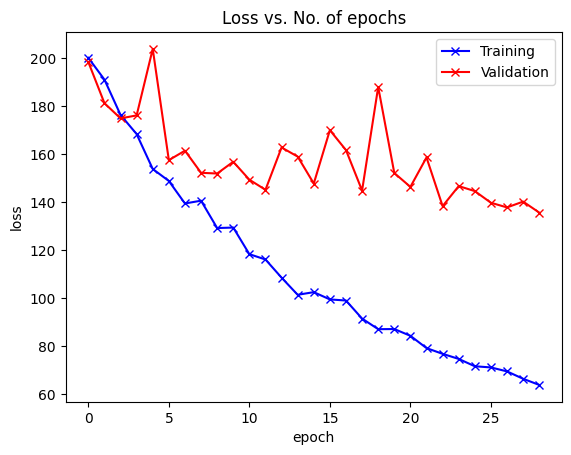

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses[1:], '-bx') # leave out first as this will distort everything (no range defined)
    plt.plot(val_losses[1:], '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

More things to consider are these:

*   Check on the test set how the model performed
*   Calculate MAE (Mean Absolute Error) to compare to https://github.com/yu4u/age-gender-estimation/blob/master/README.md
*   How to make results reproducable

In [ ]:
def calculate_MAE_MSE(dataloader):
    # calculates MAE on test set
    model.eval()
    MAE=0
    count=0

    for images, labels in dataloader:
        with torch.no_grad():
            output = model(images)
            for i in range(len(labels)):
                MAE = MAE + abs(float(output[i])-float(labels[i]))
                count+=1


    MAE = MAE/count

    out_MAE = 'MAE: ' + str(MAE) + '; '

    # calculates MSE on test set
    model.eval()
    MSE=0
    count=0

    for images, labels in dataloader:
        with torch.no_grad():
            output = model(images)
            for i in range(len(labels)):
                MSE = MSE + (float(output[i])-float(labels[i]))**2
                count+=1


    MSE = MSE/count
    out_MSE = 'MSE: ' + str(MSE)
    return out_MAE+out_MSE

print('train: \n' + str(calculate_MAE_MSE(train_dataloader)))
print('valid: \n' + str(calculate_MAE_MSE(valid_dataloader)))
print('test: \n' + str(calculate_MAE_MSE(test_dataloader)))

train: 
MAE: 4.745230401827418; MSE: 35.374716610073094
valid: 
MAE: 9.001559088985125; MSE: 135.68125247731655
test: 
MAE: 10.18658509127291; MSE: 184.98063026684585
